# **Multiclass-Classification**
# Using PyTorch and [Huggingface](https://huggingface.co/)
# On [UCC Unhealthy Comments Dataset](https://github.com/conversationai/unhealthy-conversations)

## By: Tahsin Jahin Khalid

### Setup

In [1]:
%%capture
!pip install transformers
!pip install pytorch-lightning

In [2]:
!nvidia-smi

Sat Oct  7 14:57:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import Modules

In [3]:
import os
# data processing
import numpy as np
import pandas as pd
# for visualisation
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
from transformers import AutoTokenizer
import pytorch_lightning as pl
from torch.utils.data import DataLoader
# for model selection and training
from transformers import AutoModel, get_cosine_schedule_with_warmup
from torch import optim
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F
# for evaluation
from sklearn import metrics
# for drive access
# from google.colab import drive

In [4]:
train_csv = "https://raw.githubusercontent.com/conversationai/unhealthy-conversations/main/corpus/train.csv"
valid_csv = "https://raw.githubusercontent.com/conversationai/unhealthy-conversations/main/corpus/val.csv"
test_csv = "https://raw.githubusercontent.com/conversationai/unhealthy-conversations/main/corpus/test.csv"

### Exploratory Data Analysis

In [5]:
train_data = pd.read_csv(train_csv)

In [6]:
train_data.head(5)

,_unit_id,_trusted_judgments,comment,antagonize,antagonize:confidence,condescending,condescending:confidence,dismissive,dismissive:confidence,generalisation,generalisation:confidence,generalisation_unfair,generalisation_unfair:confidence,healthy,healthy:confidence,hostile,hostile:confidence,sarcastic,sarcastic:confidence
0,2319157561,4,"Three marriages, several bankrupt periods, inh...",0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,0.7578,0,0.7565,0,1.0000
1,1739464982,4,The sense of entitlement among high school 'jo...,0,0.7634,0,0.7634,0,0.7634,0,1.0000,0.0,1.0,1,0.7634,0,0.7634,0,0.7634
2,1739457583,5,So what? He was just stating the obvious.,0,0.8121,0,0.5928,0,0.8043,0,1.0000,0.0,1.0,1,0.6163,0,1.0000,0,1.0000
3,2319156950,40,"If one is a Con, why yes, one would honk. Loud...",0,0.8508,0,0.8867,0,0.9239,0,0.8863,0.0,1.0,1,0.8508,0,0.9641,0,0.8868
4,2327196492,3,Ooohhh... It's Wendy Whiner... making sure to ...,0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,1.0000,0,1.0000,0,1.0000


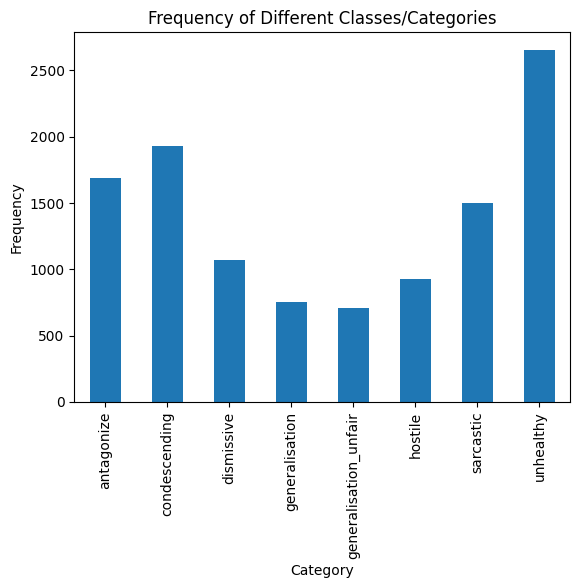

In [7]:
# we make a new variable called "unhealthy"
# which is 0 if healthy and 1 if otherwise
train_data["unhealthy"] = np.where(train_data["healthy"] == 1, 0, 1)

attributes = ["antagonize", "condescending",
              "dismissive", "generalisation",
              "generalisation_unfair", "hostile",
              "sarcastic", "unhealthy"]

train_data[attributes].sum().plot.bar()
plt.ylabel("Frequency")
plt.xlabel("Category")
plt.title("Frequency of Different Classes/Categories")
plt.show()

### Data Preparation

In [8]:
# make a custom class for the dataset
class UCC_Dataset(Dataset):

  def __init__(self, data_path, tokenizer, attributes,
               max_token_len: int = 128, sample = 5000):
    self.data_path = data_path
    self.tokenizer = tokenizer
    self.attributes = attributes
    self.max_token_len = max_token_len
    self.sample = sample
    self._prepare_data()


  def _prepare_data(self):
    data = pd.read_csv(self.data_path)
    data['unhealthy'] = np.where(data['healthy'] == 1, 0, 1)
    if self.sample is not None:
      unhealthy = data.loc[data[attributes].sum(axis=1) > 0]
      clean = data.loc[data[attributes].sum(axis=1) == 0]
      self.data = pd.concat(
          [unhealthy, clean.sample(self.sample, random_state=7)])
    else:
      self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    item = self.data.iloc[index]
    comment = str(item.comment)
    attributes = torch.FloatTensor(item[self.attributes])
    tokens = self.tokenizer.encode_plus(comment,
                                        add_special_tokens=True,
                                        return_tensors='pt',
                                        truncation=True,
                                        padding='max_length',
                                        max_length=self.max_token_len,
                                        return_attention_mask = True)
    return {'input_ids': tokens.input_ids.flatten(),
            'attention_mask': tokens.attention_mask.flatten(),
            'labels': attributes}

### Data Module

In [9]:
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
ucc_ds = UCC_Dataset(train_csv, tokenizer, attributes=attributes)
ucc_ds_val = UCC_Dataset(valid_csv, tokenizer, attributes=attributes, sample=None)

In [10]:
print(f"""
Labels:         {ucc_ds.__getitem__(0)['labels'].shape},
Input_IDs:      {ucc_ds.__getitem__(0)['input_ids'].shape},
Attention Mask: {ucc_ds.__getitem__(0)['attention_mask'].shape}
""")


Labels:         torch.Size([8]),
Input_IDs:      torch.Size([128]),
Attention Mask: torch.Size([128])



In [11]:
print(f"""
Number of Rows in Training Set:   {len(ucc_ds)}
Number of Rows in Validation Set: {len(ucc_ds_val)}
""")


Number of Rows in Training Set:   9960
Number of Rows in Validation Set: 4427



In [12]:
class UCC_Data_Module(pl.LightningDataModule):

  def __init__(self, train_path, val_path,
               attributes, batch_size: int = 16,
               max_token_length: int = 128,
               model_name='roberta-base'):
    super().__init__()
    self.train_path = train_path
    self.val_path = val_path
    self.attributes = attributes
    self.batch_size = batch_size
    self.max_token_length = max_token_length
    self.model_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)

  def setup(self, stage = None):
    if stage in (None, "fit"):
      self.train_dataset = UCC_Dataset(self.train_path,
                                       attributes=self.attributes,
                                       tokenizer=self.tokenizer)
      self.val_dataset = UCC_Dataset(self.val_path,
                                     attributes=self.attributes,
                                     tokenizer=self.tokenizer,
                                     sample=None)
    if stage == 'predict':
      self.val_dataset = UCC_Dataset(self.val_path,
                                     attributes=self.attributes,
                                     tokenizer=self.tokenizer,
                                     sample=None)

  def train_dataloader(self):
    return DataLoader(self.train_dataset,
                      batch_size = self.batch_size,
                      num_workers=4,
                      shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.val_dataset,
                      batch_size = self.batch_size,
                      num_workers=4,
                      shuffle=False)

  def predict_dataloader(self):
    return DataLoader(self.val_dataset,
                      batch_size = self.batch_size,
                      num_workers=4,
                      shuffle=False)

In [13]:
ucc_data_module = UCC_Data_Module(train_csv,
                                  valid_csv,
                                  attributes=attributes)

In [14]:
ucc_data_module.setup()

In [15]:
ucc_data_module.train_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
len(ucc_data_module.train_dataloader())

623

### Model Selection

In [17]:
class UCC_Comment_Classifier(pl.LightningModule):

  def __init__(self, config: dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(
        config['model_name'],
        return_dict = True)
    self.hidden = torch.nn.Linear(
        self.pretrained_model.config.hidden_size,
        self.pretrained_model.config.hidden_size)
    self.classifier = torch.nn.Linear(
        self.pretrained_model.config.hidden_size,
        self.config['n_labels'])
    torch.nn.init.xavier_uniform_(self.classifier.weight)
    self.loss_func = nn.BCEWithLogitsLoss(reduction='mean')
    self.dropout = nn.Dropout()

  def forward(self, input_ids, attention_mask, labels=None):
    # roberta layer
    output = self.pretrained_model(
        input_ids=input_ids,
        attention_mask=attention_mask)
    pooled_output = torch.mean(
        output.last_hidden_state, 1)
    # final logits
    pooled_output = self.dropout(pooled_output)
    pooled_output = self.hidden(pooled_output)
    pooled_output = F.relu(pooled_output)
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    # calculate loss
    loss = 0
    if labels is not None:
      loss = self.loss_func(
          logits.view(-1, self.config['n_labels']),
          labels.view(-1, self.config['n_labels']))
    return loss, logits

  def training_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("train loss ", loss,
             prog_bar = True, logger=True)
    return {"loss":loss,
            "predictions":outputs,
            "labels": batch["labels"]}

  def validation_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("validation loss ", loss,
             prog_bar = True, logger=True)
    return {"val_loss": loss, "predictions":outputs,
            "labels": batch["labels"]}

  def predict_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    return outputs

  def configure_optimizers(self):
    optimizer = optim.AdamW(self.parameters(),
                            lr=self.config['lr'],
                            weight_decay=self.config['weight_decay'])
    total_steps = self.config['train_size']/self.config['batch_size']
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                warmup_steps,
                                                total_steps)
    return [optimizer],[scheduler]

  # def validation_epoch_end(self, outputs):
  #   losses = []
  #   for output in outputs:
  #     loss = output['val_loss'].detach().cpu()
  #     losses.append(loss)
  #   avg_loss = torch.mean(torch.stack(losses))
  #   self.log("avg_val_loss", avg_loss)

In [18]:
config = {
    'model_name': 'distilroberta-base',
    'n_labels': len(attributes),
    'batch_size': 128,
    'lr': 1.5e-6,
    'warmup': 0.2,
    'train_size': len(ucc_data_module.train_dataloader()),
    'weight_decay': 0.001,
    # 'n_epochs': 100
    # reduce to 20 epoch since it took like
    # 3.5 hours or so before colab timed out
    'n_epochs': 20
}

In [19]:
model = UCC_Comment_Classifier(config)

In [20]:
idx=0
input_ids = ucc_ds.__getitem__(idx)['input_ids']
attention_mask = ucc_ds.__getitem__(idx)['attention_mask']
labels = ucc_ds.__getitem__(idx)['labels']
model.cpu()
loss, output = model(
    input_ids.unsqueeze(dim=0),
    attention_mask.unsqueeze(dim=0),
    labels.unsqueeze(dim=0))
print(labels.shape, output.shape, output)

torch.Size([8]) torch.Size([1, 8]) tensor([[ 0.1903,  0.0589,  0.3509, -0.2044,  0.0438, -0.3039,  0.2462, -0.3153]],
       grad_fn=<AddmmBackward0>)


### Model Training

In [21]:
# datamodule
ucc_data_module = UCC_Data_Module(train_csv,
                                  valid_csv,
                                  attributes=attributes,
                                  batch_size=config['batch_size'])
ucc_data_module.setup()

# model
model = UCC_Comment_Classifier(config)

# trainer and fit
trainer = pl.Trainer(
    max_epochs=config['n_epochs'],
    devices=1,
    accelerator="gpu",
    num_sanity_val_steps=50)
trainer.fit(model, ucc_data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type              | Params
-------------------------------------------------------
0 | pretrained_model | RobertaModel      | 82.1 M
1 | hidden           | Linear            | 590 K 
2 | classifier       | Linear            | 6.2 K 
3 | loss_func        | BCEWithLogitsLoss | 0     
4 | dropout          | Dropout           | 0     
-------------------------------------------------------
82.7 M    Trainable params
0         Non-trainable params
82.7 M    Total params
330.861   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


### Model Prediction

In [22]:
# method to convert list of comments into predictions for each comment
def classify_raw_comments(model, dm):
  predictions = trainer.predict(
      model,
      datamodule=dm)
  flattened_predictions = np.stack(
      [torch.sigmoid(torch.Tensor(p))
       for batch in predictions
       for p in batch])
  return flattened_predictions

In [23]:
predictions = classify_raw_comments(model, ucc_data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Predicting: 0it [00:00, ?it/s]

In [24]:
val_data = pd.read_csv(valid_csv)
val_data['unhealthy'] = np.where(val_data['healthy'] == 1, 0, 1)
true_labels = np.array(val_data[attributes])

### Model Evaluation

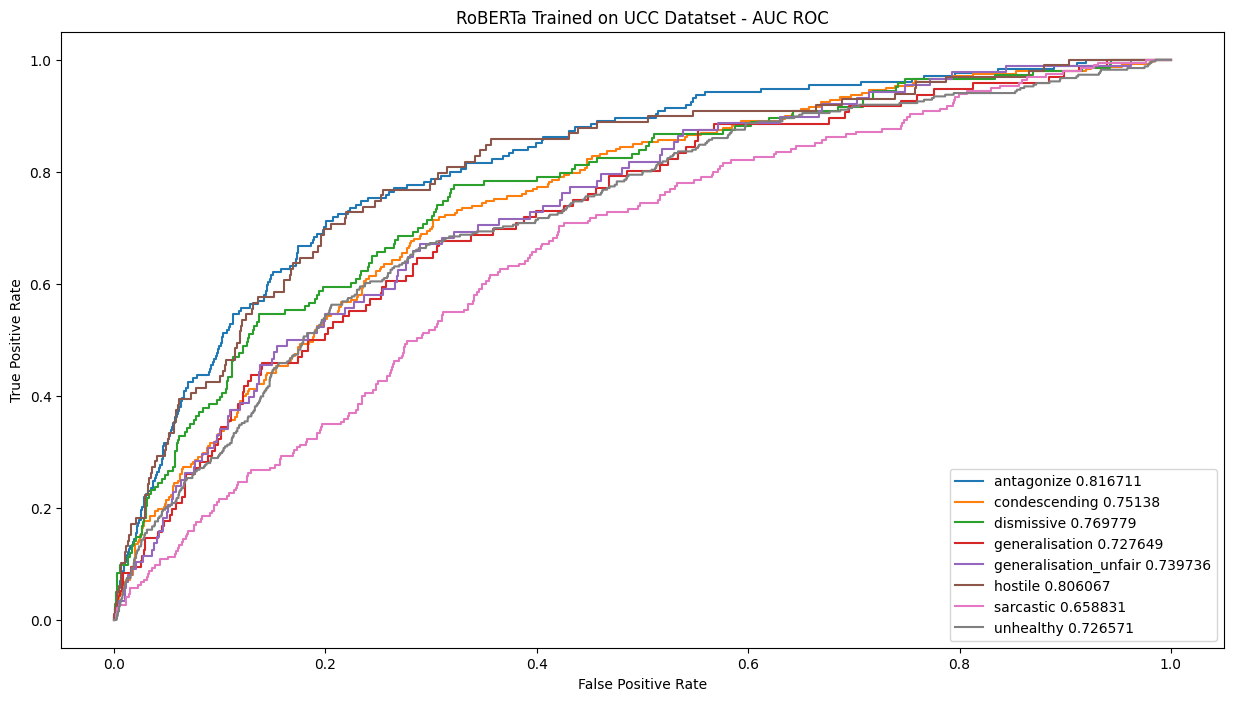

In [25]:
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      true_labels[:,i].astype(int), predictions[:, i])
  auc = metrics.roc_auc_score(
      true_labels[:,i].astype(int), predictions[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('RoBERTa Trained on UCC Datatset - AUC ROC')
plt.show()